In [1]:
import os
import sys
import warnings
import numpy as np
import dask.distributed as dd
from dask.utils import format_bytes
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dateutil.parser import parse
from aqua import Reader, util, logger
from datetime import datetime
from aqua.exceptions import NotEnoughDataError, NoDataError, NoObservationError
import pandas as pd
import argparse

import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

#logger = logger.log_configure(log_level='INFO', log_name='ssh_logger')


In [2]:
config = util.load_yaml('../config1.yml')


In [3]:
def check_time_span(config, ds, start, end):
    """
    Check if the required time span defined by start and end is within the 
    time span of the xarray data.

    Parameters:
    - ds: xarray Dataset or DataArray with a time coordinate.
    - start: Start of the required time span.
    - end: End of the required time span.

    Returns:
    - bool: True if the required time span is within the xarray data's time span, False otherwise.
    """
    #aqua_logger = logger.log_configure(log_level=config['log_level'], log_name=config['log_name'])

    # Convert start and end strings to datetime objects
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')

    #aqua_logger.debug("start_date: %s", start_date)
    #aqua_logger.debug("end_date: %s", end_date)

    # Extract the time coordinate from the xarray data
    time_coord = ds['time']

    # Ensure the min and max time coordinates are in datetime format for comparison
    time_min = pd.to_datetime(time_coord.min().values)
    time_max = pd.to_datetime(time_coord.max().values)

    #aqua_logger.debug("time_min: %s", time_min)
    #aqua_logger.debug("time_max: %s", time_max)

    # Check if the config specifies checking for the complete time span
    if config.get('check_complete_timespan', False):
        return True
    else:
        # Check if the required time span is within the xarray data's time span
        return start_date >= time_min and end_date <= time_max


In [4]:
for model_name in config['models']:

            try:
                reader = Reader(model=model_name['name'], exp=model_name['experiment'],
                            source=model_name['source'], regrid=model_name['regrid'], zoom=model_name['zoom'], fix=True)
            except:
                raise NoDataError("Model data not found.")
                
            model_data = reader.retrieve()

            ssh_data = model_data[model_name['variable']]
            if 'timespan' in model_name and model_name['timespan']:
                if not check_time_span(config, ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
                    raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                    sys.exit(0)
                timespan_start = parse(model_name['timespan'][0])
                timespan_end = parse(model_name['timespan'][1])

            else:
                warnings.warn(
                    "Model does not have a custom timespan, using default.", UserWarning)

2023-12-04 12:14:09 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-12-04 12:14:09 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-12-04 12:14:09 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-12-04 12:14:09 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-12-04 12:15:26 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-12-04 12:15:26 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-12-04 12:15:26 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-12-04 12:15:26 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 2625

In [5]:
import sys
sys.path.insert(0, '../../')
from ssh_jal import sshVariability

In [6]:
%%time
analyzer = sshVariability('../config1.yml')
#analyzer.run()
# runtime is around 7-8 min depending on how much data you wish to analyse.

CPU times: user 7.68 ms, sys: 466 µs, total: 8.14 ms
Wall time: 8.04 ms


In [7]:

try:
    reader = Reader(model=config['base_model']['name'], exp=config['base_model']
                        ['experiment'], source=config['base_model']['source'], fix=True)
except:
    raise NoObservationError("AVISO data not found.")

2023-12-04 12:15:26 :: Reader :: WARNING  -> No fixes available for model AVISO


In [8]:
aviso_cat = reader.retrieve()
timespan_start = config['timespan']['start']
timespan_end = config['timespan']['end']


In [9]:
aviso_cat


<xarray.Dataset>
Dimensions:         (time: 10766, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-06-23
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [20]:
aviso_ssh = aviso_cat['adt']


In [11]:
check_time_span(config,aviso_ssh, timespan_start, timespan_end)


True

In [15]:
def validate_time_ranges(config):
    """
    Validate the time ranges for each model in the configuration.
    Raises a warning if the time ranges are not equal across models.

    Args:
        config (dict): Configuration dictionary.
    """
    # time_ranges is a list that contains the time differences for each model's time range.
    # time_ranges = [parse(model['timespan'][0]) - parse(model['timespan'][1]) for model in config['models']]
    time_ranges = []
    for model in config['models']:
        if model.get('timespan'):
            start_time = parse(model['timespan'][0])
            end_time = parse(model['timespan'][1])
            time_ranges.append(start_time - end_time)

    # set(time_ranges) creates a set from the time_ranges list, removing any duplicate values. A set is an unordered collection of unique elements.
    # len(set(time_ranges)) gives the number of unique elements in the set, which indicates the number of different time ranges present in the time_ranges list.
    # len(set(time_ranges)) > 1 checks if there is more than one unique time range in the time_ranges list.
    # If the condition is true, it means that the time ranges are not equal across models, and further action can be taken based on this information.
    if len(set(time_ranges)) > 1:
        logger.warning("Time ranges are not equal across models.")
    return time_ranges

In [16]:
validate_time_ranges(config)


[datetime.timedelta(days=-153)]

In [17]:
def create_output_directory(config):
        # Check if the output_directory key exists in the config dictionary
        if 'output_directory' in config:
            output_directory = config['output_directory']
            os.makedirs(output_directory, exist_ok=True)
        else:
            logger.warning(
                "Output directory not found in config file. Outputs will be saved in a directory named 'output' in your current working directory.")
            # Create a directory named 'output' in the current working directory
            output_directory = os.path.join(os.getcwd(), 'output')
            os.makedirs(output_directory, exist_ok=True)

        return output_directory

In [18]:
def save_standard_deviation_to_file(output_directory, model_name, std_dev_data):
        """
        Save the standard deviation data to a NetCDF file.

        Args:
            output_directory (str): Directory to save the output file.
            model_name (str): Name of the model.
            std_dev_data (xarray.DataArray): Computed standard deviation data.
        """
        # Create the file type folder within the output directory
        file_type_folder = os.path.join(output_directory, "netcdf")
        os.makedirs(file_type_folder, exist_ok=True)

        # Set the output file path
        output_file = os.path.join(file_type_folder, f"{model_name}_std.nc")
        # output_file = os.path.join(output_directory, f"{model_name}_std.nc")
        std_dev_data.to_netcdf(output_file)


In [19]:
aviso_ssh_std = aviso_ssh.sel(time=slice(
            timespan_start, timespan_end)).std(axis=0).persist()


/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [20]:
def save_standard_deviation_to_file(output_directory, model_name, std_dev_data):
        """
        Save the standard deviation data to a NetCDF file.

        Args:
            output_directory (str): Directory to save the output file.
            model_name (str): Name of the model.
            std_dev_data (xarray.DataArray): Computed standard deviation data.
        """
        # Create the file type folder within the output directory
        file_type_folder = os.path.join(output_directory, "netcdf")
        os.makedirs(file_type_folder, exist_ok=True)

        # Set the output file path
        output_file = os.path.join(file_type_folder, f"{model_name}_std.nc")
        # output_file = os.path.join(output_directory, f"{model_name}_std.nc")
        std_dev_data.to_netcdf(output_file)

In [21]:
def create_output_directory(config):
        # Check if the output_directory key exists in the config dictionary
        if 'output_directory' in config:
            output_directory = config['output_directory']
            os.makedirs(output_directory, exist_ok=True)
        else:
            logger.warning("Output directory not found in config file. Outputs will be saved in a directory named 'output' in your current working") 

In [22]:
    def visualize_subplots(config, ssh_data_dict, fig, axes):
        """
        Visualize the SSH variability data as subplots using Cartopy.

        Args:
            config (dict): The configuration dictionary containing the flags for masking the boundaries.
            ssh_data_dict (dict): Dictionary of SSH variability data arrays with model names to visualize.
            fig (plt.Figure): The figure object for the subplots.
            axes (list): List of subplot axes.
        """
        
        # ref_model_name, ref_data = next(iter(ssh_data_dict.items()))
        
        # Retrieve the masking flags and boundary latitudes from the configuration
        mask_northern_boundary = config.get("mask_northern_boundary", False)
        mask_southern_boundary = config.get("mask_southern_boundary", False)
        northern_boundary_latitude = config.get("northern_boundary_latitude", None)
        southern_boundary_latitude = config.get("southern_boundary_latitude", None)

        for i, (model_name, data) in enumerate(ssh_data_dict.items()):
            if i < len(axes):
                ax = axes[i]

               
                # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
                if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
                    data = data.where(data.lat < northern_boundary_latitude)
                if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
                    data = data.where(data.lat > southern_boundary_latitude)
                # Create a contour plot on the current axis
                
                # levels = np.linspace(
                    # config["subplot_options"]["scale_min"], config["subplot_options"]["scale_max"], num=100)
               
                if 'lon' in data.coords:
                    contf = ax.pcolormesh(data.lon.values, data.lat.values, data, transform=ccrs.PlateCarree(), 
                                      vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                                      cmap=config["subplot_options"]["cmap"])
                else:
                    contf = ax.pcolormesh(data.longitude.values, data.latitude.values, data, transform=ccrs.PlateCarree(), 
                                      vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                                      cmap=config["subplot_options"]["cmap"])
                ax.set_title(f"{model_name}")
                ax.coastlines()               
                
                # Add a colorbar for each subplot
                cbar = fig.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
                cbar.set_label('SSH Variability (mm)')


        if len(ssh_data_dict) < len(axes):
            for j in range(len(ssh_data_dict), len(axes)):
                fig.delaxes(axes[j])
        fig.tight_layout()


In [151]:
def visualize_difference(config, ssh_data_dict, fig, axes):
    """
    Visualize the difference in SSH variability data between each model and the first model.

    Args:
        config (dict): The configuration dictionary containing the flags for masking the boundaries.
        ssh_data_dict (dict): Dictionary of SSH variability data arrays with model names to visualize.
        fig (plt.Figure): The figure object for the subplots.
        axes (list): List of subplot axes.
    """
    # Retrieve the masking flags and boundary latitudes from the configuration
    mask_northern_boundary = config.get("mask_northern_boundary", False)
    mask_southern_boundary = config.get("mask_southern_boundary", False)
    northern_boundary_latitude = config.get("northern_boundary_latitude", None)
    southern_boundary_latitude = config.get("southern_boundary_latitude", None)

    # Get the first model as the reference
    ref_model_name, ref_data = next(iter(ssh_data_dict.items()))

    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        if i < len(axes) and model_name != ref_model_name:
            
            ax = axes[i]
            # Calculate the difference between the current model and the reference model
            diff_data = ref_data.values - data.values

            # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
            if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
                diff_data = data.where(data.lat < northern_boundary_latitude)
            if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
                diff_data = data.where(data.lat > southern_boundary_latitude)

            # Check if the difference is non-zero before plotting
            if not np.allclose(diff_data, 0):
                # Create a contour plot for the difference on the current axis
                #if 'lon' in data.coords:
                contf = ax.pcolormesh(data.lon.values, data.lat.values, diff_data,
                                      transform=ccrs.PlateCarree(),
                                      vmin=-0.8,
                                      vmax=0.8,
                                      cmap="RdBu")
                # else:
                #     contf = ax.pcolormesh(data.longitude.values, data.latitude.values, diff_data,
                #                           transform=ccrs.PlateCarree(),
                #                           vmin=config["subplot_options"]["scale_min"],
                #                           vmax=config["subplot_options"]["scale_max"],
                #                           cmap=config["subplot_options"]["cmap"])
                ax.set_title(f"{model_name} - Difference from {ref_model_name}")
                ax.coastlines()

                # Add a colorbar for each subplot
                cbar = fig.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
                cbar.set_label('SSH Variability Difference (mm)')

    if len(ssh_data_dict) < len(axes):
        for j in range(len(ssh_data_dict), len(axes)):
            fig.delaxes(axes[j])
    fig.tight_layout()


CPU times: user 5.1 s, sys: 599 ms, total: 5.7 s
Wall time: 5.9 s


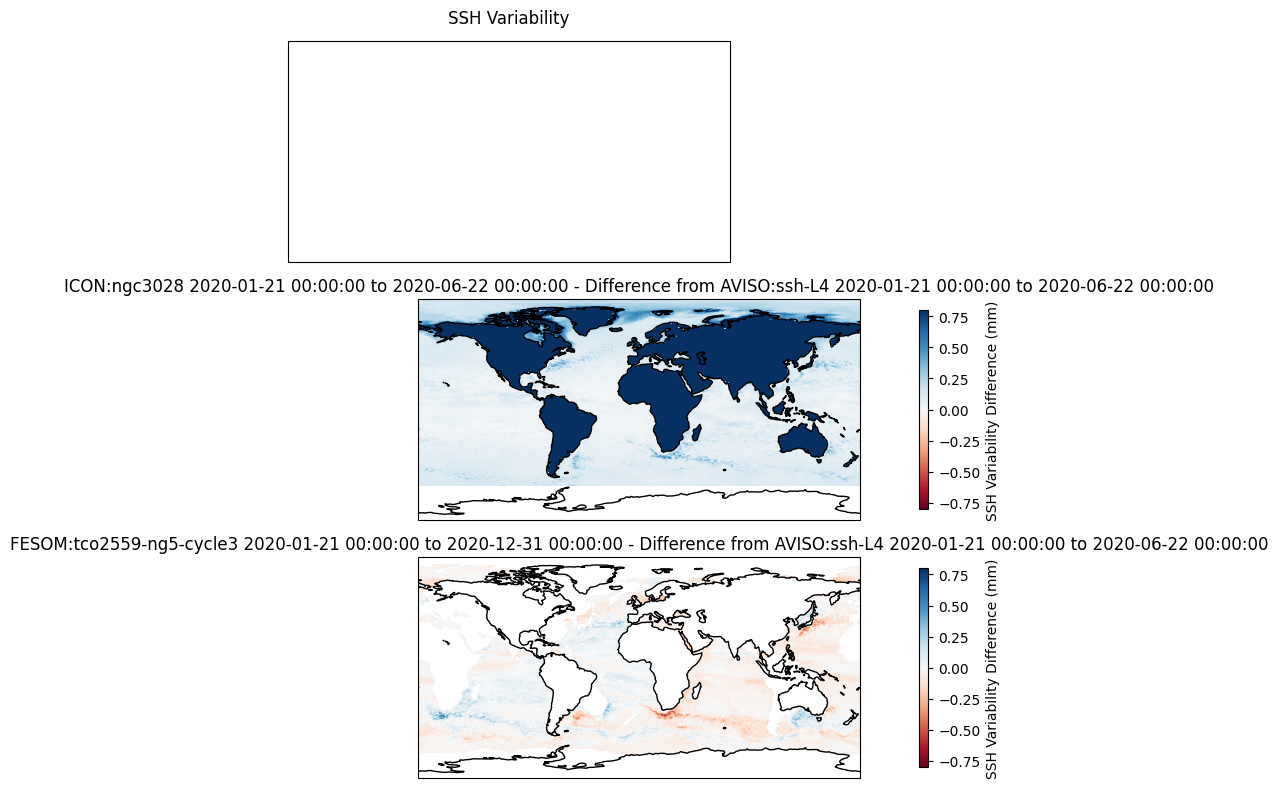

In [152]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

visualize_difference(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

In [39]:
aviso = ssh_data_dict['AVISO:ssh-L4 2020-01-20 to 2021-12-31']


In [61]:
icon=ssh_data_dict['ICON:ngc3028 2020-01-21 00:00:00 to 2020-06-22 00:00:00']


In [41]:
fesom = ssh_data_dict['FESOM:tco2559-ng5-cycle3 2020-01-21 00:00:00 to 2020-12-31 00:00:00']

2023-12-04 12:45:32 :: cbar get label :: WARNING  -> No colorbar label found, please specify one with the cbar_label argument.


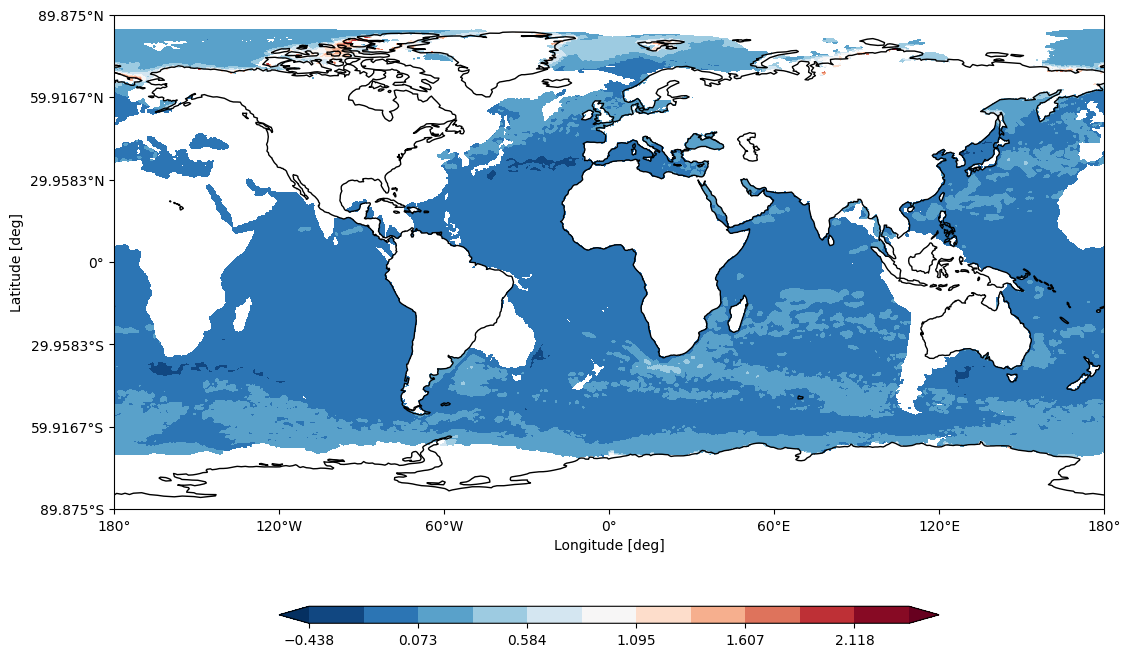

In [90]:
from aqua import plot_single_map
ssh_plot = aviso_ssh.isel(time=1)
ssh_plot = ssh_plot.rename({'longitude': 'lon'})
ssh_plot = ssh_plot.rename({'latitude': 'lat'})
ssh_plot
plot_single_map(diff)

In [113]:
# diff = aviso.values - icon.values

da1, da2 = xr.align(fesom, aviso, join='exact')


In [114]:
da1 = da1.compute()
da2 = da2.compute()

In [115]:
diff = da2.values - da1.values
diff = xr.DataArray(diff, coords={'lat': icon.lat, 'lon': icon.lon}, dims=['lat', 'lon'])

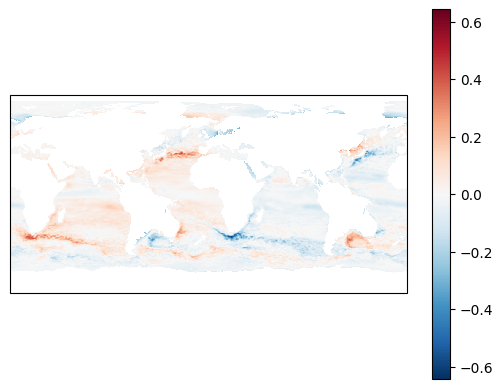

In [117]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face')
ax.add_feature(land_feature, color='none', edgecolor='none', alpha=0.5)

diff.plot(ax=ax)

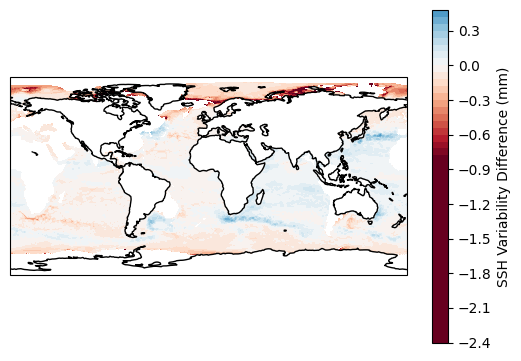

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

# Assuming aviso and icon are xarray DataArrays
icon = xr.where(icon>3,np.nan,icon)
# icon = icon.rename({'lon': 'longitude'})
# icon = icon.rename({'lat': 'latitude'})


diff = aviso.values - icon.values
# diff = xr.Dataset(
#     {'ssh': (['lat', 'lon'], diff)},
#     coords={'lat': icon.lat, 'lon': icon.lon}
# )

diff = xr.DataArray(diff, coords={'lat': icon.lat, 'lon': icon.lon}, dims=['lat', 'lon'])


# Create a GeoAxes using cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data on the GeoAxes using contourf
contf = ax.contourf(aviso.longitude.values, aviso.latitude.values, diff,
                    transform=ccrs.PlateCarree(),
                    levels=50,  # Adjust the number of contour levels as needed
                    cmap="RdBu", vmin=-0.8, vmax=0.8)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
cbar.set_label('SSH Variability Difference (mm)')

plt.show()


MemoryError: Unable to allocate 7.82 TiB for an array with shape (720, 1440, 720, 1440) and data type float64

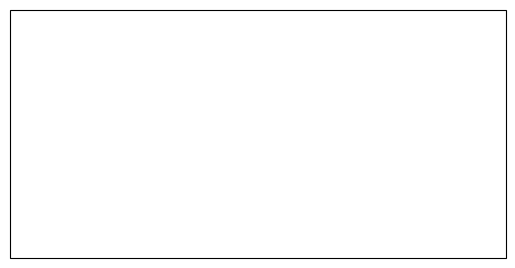

In [56]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

# Assuming aviso and icon are xarray DataArrays
aviso, icon = xr.align(aviso, icon)
icon = xr.where(icon>3,np.nan,icon)

aviso['longitude'] = (aviso['longitude'] + 180) % 360 - 180
icon['lon'] = (icon['lon'] + 180) % 360 - 180

# Interpolate (regrid) the icon dataset to the aviso grid
icon_regridded = icon.interp_like(aviso, method='linear')

# Calculate the difference
diff = aviso - icon_regridded

# Close any existing figures
for fig_num in plt.get_fignums():
    plt.close(fig_num)

# Create a new figure using plt.figure() and GeoAxes using plt.axes()
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data on the GeoAxes using contourf
contf = ax.contourf(aviso.longitude.values, aviso.latitude.values, diff,
                    transform=ccrs.PlateCarree(),
                    levels=50,  # Adjust the number of contour levels as needed
                    cmap="RdBu", vmin=-1, vmax=1)

# Add coastlines
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
cbar.set_label('SSH Variability Difference (mm)')

plt.show()


In [137]:
for i, (model_name, data) in enumerate(ssh_data_dict.items()):
    # diffdata = data.values - ref_data.values
    # d1=data
    # d2=data
    
    var_name = f"variable_{i}"
    print(var_name)
    globals()[var_name] = data
# ref_model_name, ref_data = next(iter(ssh_data_dict.items()))


variable_0
variable_1


In [276]:
print(variable_0.longitude.values)
# print(variable_1.lon)

[-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]


In [307]:
mm = xr.where(variable_1>3,np.nan,variable_1)
mm['lon'] = ref_data['longitude'].values.T
# mm.plot(vmin=0,vmax=.5)


In [309]:
variable_0

<xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

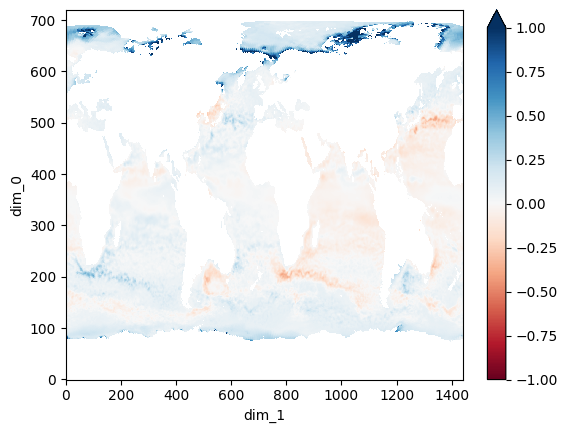

In [281]:
# variable_0.plot(vmin=0,vmax=.5)
diff = mm.values - variable_0.values
# var1 = variable_0.rename({'latitude': 'lat'})
# var1 = var1.rename({'longitude': 'lon'})
# diff = mm['zos'] - var1['adt']
# plt.plot(diff)
diff =  xr.DataArray(diff)
diff.plot(vmin=-1, vmax=1, cmap = 'RdBu')

In [106]:
ssh_data_dict['AVISO:ssh-L4 2020-01-20 to 2021-12-31']

<xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [55]:
@staticmethod
def visualize_subplots(config, ssh_data_dict, fig, axes):
    """
    Visualize the SSH variability data as subplots using Cartopy.

    Args:
        config (dict): The configuration dictionary containing the flags for masking the boundaries.
        ssh_data_dict (dict): Dictionary of SSH variability data arrays with model names to visualize.
        fig (plt.Figure): The figure object for the subplots.
        axes (list): List of subplot axes.
    """
    ref_model_name, ref_data = next(iter(ssh_data_dict.items()))
    # Retrieve the masking flags and boundary latitudes from the configuration
    mask_northern_boundary = config.get("mask_northern_boundary", False)
    mask_southern_boundary = config.get("mask_southern_boundary", False)
    northern_boundary_latitude = config.get("northern_boundary_latitude", None)
    southern_boundary_latitude = config.get("southern_boundary_latitude", None)

    num_models = len(ssh_data_dict)
    num_cols = 3  # Number of columns for SSH Variability and Difference subplots

    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        row_idx = i // num_cols
        col_idx = i % num_cols

        # SSH Variability Plot
        ax_ssh = axes[i]
        ax_ssh.set_title(f"{model_name} - SSH Variability")
        ax_ssh.coastlines()
        # Your SSH Variability plotting logic goes here...

        # Difference Plot
        ax_diff_idx = i + num_models
        if ax_diff_idx < len(axes):
            ax_diff = axes[ax_diff_idx]
            ax_diff.set_title(f"{model_name} - Difference from {ref_model_name}")
            ax_diff.coastlines()
            # Your Difference plotting logic goes here...
    
    fig.tight_layout()


In [12]:
aviso_ssh_std = aviso_ssh.sel(time=slice(
            timespan_start, timespan_end)).std(axis=0).persist()
        # saving the computation in output files
#save_standard_deviation_to_file(create_output_directory(
#            config), "AVISO_ssh-L4_daily", aviso_ssh_std)

        
ssh_data_dict = {}
        # ssh_data_dict[config['base_model']['name']] = aviso_ssh_std
ssh_data_dict[f"{config['base_model']['name']}:{config['base_model']['experiment']} {timespan_start} to {timespan_end}"] = aviso_ssh_std

/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [13]:
for model_name in config['models']:

            try:
                reader = Reader(model=model_name['name'], exp=model_name['experiment'],
                            source=model_name['source'], regrid=model_name['regrid'], zoom=model_name['zoom'], fix=True)
            except:
                raise NoDataError("Model data not found.")
            
            model_data = reader.retrieve()

            ssh_data = model_data[model_name['variable']]

            model_data_time_min = np.datetime64(model_data.time.min().values)
            model_data_time_max = np.datetime64(model_data.time.max().values)
            
            if config.get('check_complete_timespan_models', False):
                timespan_start = model_data_time_min
                timespan_end = model_data_time_max 
                
            else:
            
                if 'timespan' in model_name and model_name['timespan']:
                    if not check_time_span(config, ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
                        raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                        sys.exit(0)
                    timespan_start = parse(model_name['timespan'][0])
                    timespan_end = parse(model_name['timespan'][1])

                else:
                    warnings.warn(
                        "Model does not have a custom timespan, using default.", UserWarning)
                    if not check_time_span(config, ssh_data, config['timespan']['start'], config['timespan']['end']):
                        raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                        sys.exit(0)
                    timespan_start = config['timespan']['start']
                    timespan_end = config['timespan']['end']
            ssh_std_dev_data = ssh_data.sel(time=slice(timespan_start, timespan_end)).std(
                axis=0, keep_attrs=True).persist()
            # saving the computation in output files
            model_info = f"{model_name['name']}_{model_name['experiment']}_{model_name['source']}"
            # self.save_standard_deviation_to_file(config['output_directory'], model_name['name'], ssh_std_dev_data)

            # regridding the data and plotting for visualization
            ssh_std_dev_regrid = reader.regrid(ssh_std_dev_data)
            # ssh_data_dict[model_name['name']] = ssh_std_dev_regrid
            ssh_data_dict[f"{model_name['name']}:{model_name['experiment']} {timespan_start} to {timespan_end}"] = ssh_std_dev_regrid
    
    
            # computing std

2023-12-04 12:16:07 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-12-04 12:16:07 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-12-04 12:16:07 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-12-04 12:16:07 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
2023-12-04 12:16:16 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-12-04 12:16:16 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-12-04 12:16:16 :: 

In [56]:
aviso=ssh_data_dict.get('AVISO:ssh-L4 2020-06-21 00:00:00')

In [57]:
icon=ssh_data_dict.get('ICON:ngc3028 2020-06-21 to 2020-07-23')

In [39]:
ssh_data_dict

{'AVISO:ssh-L4 2020-01-21 00:00:00 to 2020-06-22 00:00:00': <xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
 dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     comment:        The absolute dynamic topography is the sea surface height...
     grid_mapping:   crs
     long_name:      Absolute dynamic topography
     standard_name:  sea_surface_height_above_geoid
     units:          m,
 'ICON:ngc3028 2020-01-21T00:00:00.000000000 to 2025-07-22T00:00:00.000000000': <xarray.DataArray 'zos' (lat: 720, lon: 1440)>
 dask.array<reshape, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 0.0 0.25 0.5 0.

CPU times: user 23.1 ms, sys: 4.07 ms, total: 27.2 ms
Wall time: 31.7 ms


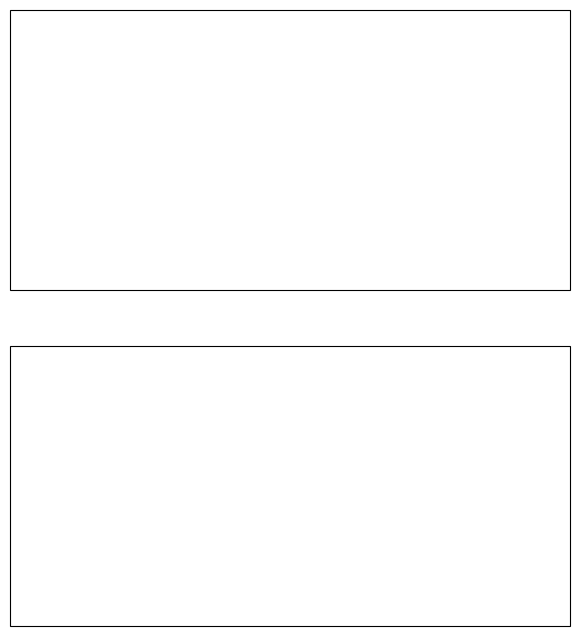

In [23]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

#plt.savefig('ff1.pdf')

In [24]:
visualize_subplots(config, ssh_data_dict, fig, axes)

In [21]:
ssh_data_dict

{'AVISO:ssh-L4 2020-06-21 00:00:00 to 2020-07-23 00:00:00': <xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
 dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     comment:        The absolute dynamic topography is the sea surface height...
     grid_mapping:   crs
     long_name:      Absolute dynamic topography
     standard_name:  sea_surface_height_above_geoid
     units:          m}

In [19]:
for model_name in config['models']:
    ssh_data = model_data[model_name['variable']]
    ssh_std_dev_data = ssh_data.sel(time=slice(timespan_start, timespan_end)).std(
                axis=0, keep_attrs=True).persist()
    ssh_std_dev_regrid = reader.regrid(ssh_std_dev_data)

    ssh_data_dict[f"{model_name['name']}:{model_name['experiment']} {model_name['timespan'][0]} to {model_name['timespan'][1]}"] = ssh_std_dev_regrid
            # ssh_data_dict[model_name['name']] = ssh_std_dev_regrid
    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        print(model_name)
        if i < len(axes):
            ax = axes[i]


AVISO:ssh-L4 2015-01-20 to 2021-12-31
ICON:ngc3028 2020-06-21 to 2020-07-23


/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [20]:
ssh_data_dict

{'AVISO:ssh-L4 2015-01-20 to 2021-12-31': <xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
 dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     comment:        The absolute dynamic topography is the sea surface height...
     grid_mapping:   crs
     long_name:      Absolute dynamic topography
     standard_name:  sea_surface_height_above_geoid
     units:          m,
 'ICON:ngc3028 2020-06-21 to 2020-07-23': <xarray.DataArray 'zos' (lat: 720, lon: 1440)>
 dask.array<reshape, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
 Attributes:
     cel

In [26]:
data.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    units:          degrees_east
    standard_name:  longitude
    axis:           X

In [73]:
a=ssh_data_dict['AVISO:ssh-L4 2020-01-20 to 2021-12-31']
b=ssh_data_dict['ICON:ngc3028 2020-01-21 00:00:00 to 2020-06-22 00:00:00']

diff = b.values-a.values
diff = xr

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [112]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

visualize_subplots(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

CPU times: user 2.15 s, sys: 117 ms, total: 2.26 s
Wall time: 2.38 s


skipping AVISO
skipping AVISO
CPU times: user 219 ms, sys: 62.4 ms, total: 281 ms
Wall time: 477 ms


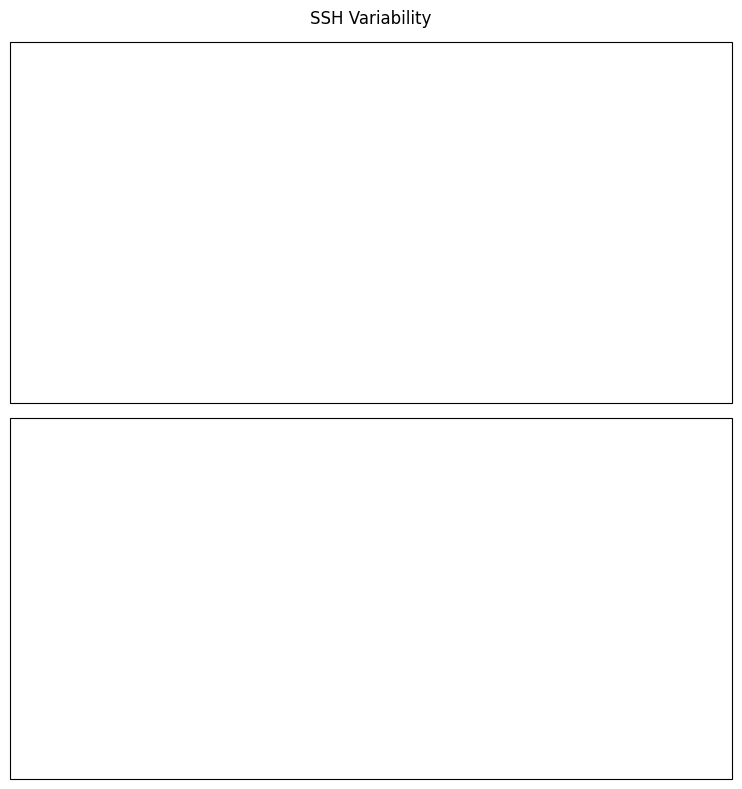

In [117]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

visualize_diffplots(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

In [30]:
for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        if i < len(axes):
            ax = axes[i]

            # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
            mask_northern_boundary = config.get("mask_northern_boundary", False)
            mask_southern_boundary = config.get("mask_southern_boundary", False)
            northern_boundary_latitude = config.get("northern_boundary_latitude", None)
            southern_boundary_latitude = config.get("southern_boundary_latitude", None)
            if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
                data = data.where(data.lat < northern_boundary_latitude)
            if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
                data = data.where(data.lat > southern_boundary_latitude)


In [117]:
data.lat

<xarray.DataArray 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875])
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Attributes:
    units:          degrees_north
    standard_name:  latitude
    axis:           Y